# Simple U-Net Demo

### Configurations

In [1]:
IMAGE_SIZE = 640
BATCH_SIZE = 1

### Import Dependencies & Initialization

In [2]:
import os
os.chdir('..')   # change the directory from 'examples' to root

import numpy as np
import tensorflow as tf
from IPython.display import clear_output

import pneumo
import Augmentor
import tfAugmentor

### Load Kaggle 'SIIM-ACR Pneumothorax Segmentation Challenge' dataset
https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation

In [3]:
ds = pneumo.data.load_siim('data/siim-acr')

### Train-test split

In [4]:
N_data = sum(1 for _ in ds)
N_test = int(N_data*0.1)
N_val = int(N_data*0.1)
N_train = N_data - N_val - N_test

print(f'Total number of samples: {N_data}')
print(f'  Train: {N_train}')
print(f'  Validation: {N_val}')
print(f'  Test: {N_test}')

Total number of samples: 2379
  Train: 1905
  Validation: 237
  Test: 237


In [5]:
test_ds = ds.take(N_test)
train_ds = ds.skip(N_test)
val_ds = train_ds.take(N_val)
train_ds = train_ds.skip(N_val)

### Data Augmentation and Preprocessing

In [6]:
def preprocess(image, label):
    return tf.keras.applications.mobilenet_v2.preprocess_input(image), label

def unpreprocess(image, label=None):
    image = tf.cast((0.5*image+0.5)*255, tf.uint8)
    if label is None:
        return image
    else:
        return image, label

In [8]:
train_transforms = [
    pneumo.augmentations.random_crop((IMAGE_SIZE,IMAGE_SIZE)),
    pneumo.augmentations.random_intensity(5),
    pneumo.augmentations.random_noise(1),
    preprocess
]
test_transforms = [
    pneumo.augmentations.random_crop((IMAGE_SIZE,IMAGE_SIZE)),
    preprocess
]

In [9]:
train_augment = tfAugmentor.Augmentor(('image', 'mask'), image=['image'], label=['mask'])

train_augment.flip_left_right(probability=0.5)
train_augment.random_rotate(probability=0.5)
train_augment.elastic_deform(strength=2, scale=20, probability=1)

train_ds = train_augment(train_ds, keep_size=True)

Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: generators are not supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Anaconda3\envs\pneumo\lib\site-packages\tensorflow\python\autograph\impl\api.py:493: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  return py_builtins.overload_of(f)(*args)


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [10]:
for transform in train_transforms:
    train_ds = train_ds.map(transform)
for transform in test_transforms:
    val_ds = val_ds.map(transform)
    test_ds = test_ds.map(transform)

train_ds = train_ds.shuffle(512).repeat().batch(BATCH_SIZE).prefetch(1)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

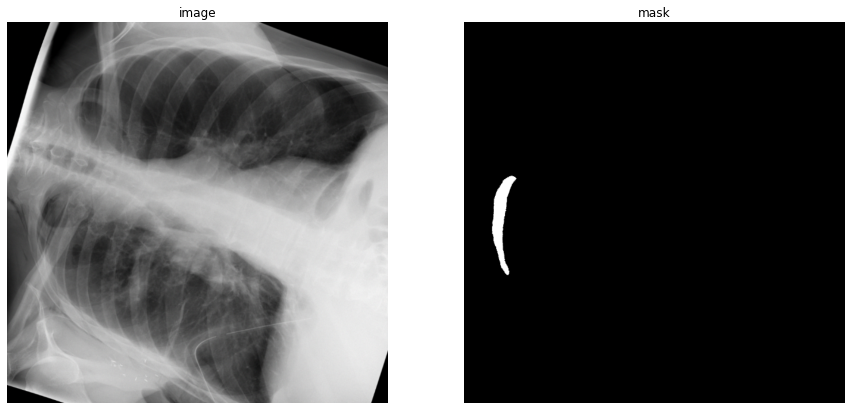

In [11]:
for image, mask in train_ds.take(1):
    pneumo.display(
        [image[0], mask[0]],
        ['image', 'mask'],
        ['gray', 'gray']
    )

### Build and compile U-Net

In [26]:
model = pneumo.models.UNet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=pneumo.losses.combined_loss(1,4,3),
              metrics=[pneumo.metrics.dice])

In [27]:
# code modified from https://www.tensorflow.org/tutorials/images/segmentation

def create_mask(pred_mask):
    pred_mask = tf.nn.sigmoid(pred_mask) > 0.5
    pred_mask = tf.cast(pred_mask, tf.int32)
    return pred_mask

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            pnemo.display(
                [image[0], mask[0], tf.nn.sigmoid(pred_mask[0]), create_mask(pred_mask[0])],
                ['Input Image', 'True Mask', 'Heat Map', 'Predicted Mask'],
                [None, 'gray', 'inferno', 'gray']
            )
    else:
        for image, mask in val_ds.take(num):
            pred_mask = model.predict(image)
            pneumo.display(
                [image[0], mask[0], tf.nn.sigmoid(pred_mask[0]), create_mask(pred_mask[0])],
                ['Input Image', 'True Mask', 'Heat Map', 'Predicted Mask'],
                [None, 'gray', 'inferno', 'gray']
            )

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        scheduled_lr = lr*0.95
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print ('\nSample Prediction after epoch {}'.format(epoch+1))
        print('Learning rate: {}\n'.format(scheduled_lr))

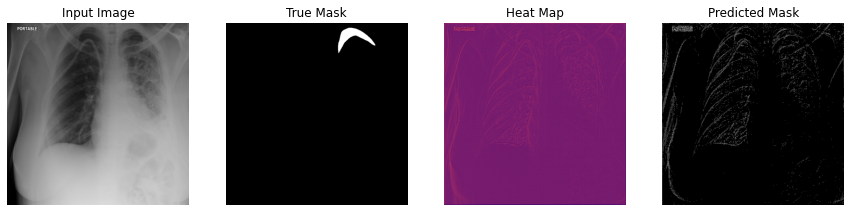

In [14]:
show_predictions()

### Train Model

In [ ]:
EPOCHS = 50

model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/{epoch:02d}-{val_loss:.2f}', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
)

model_history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=N_train,
    callbacks=[model_ckpt, CustomCallback()],
    validation_data=val_ds,
)

Epoch 1/50
  80/1905 [>.............................] - ETA: 38:31 - loss: 1.2555 - dice: 0.0428

### Model Load and Test on a Sample Query

In [ ]:
del model
model = tf.keras.models.load_model("mymodel", custom_objects={'dice':dice, 'loss':loss})
show_predictions()

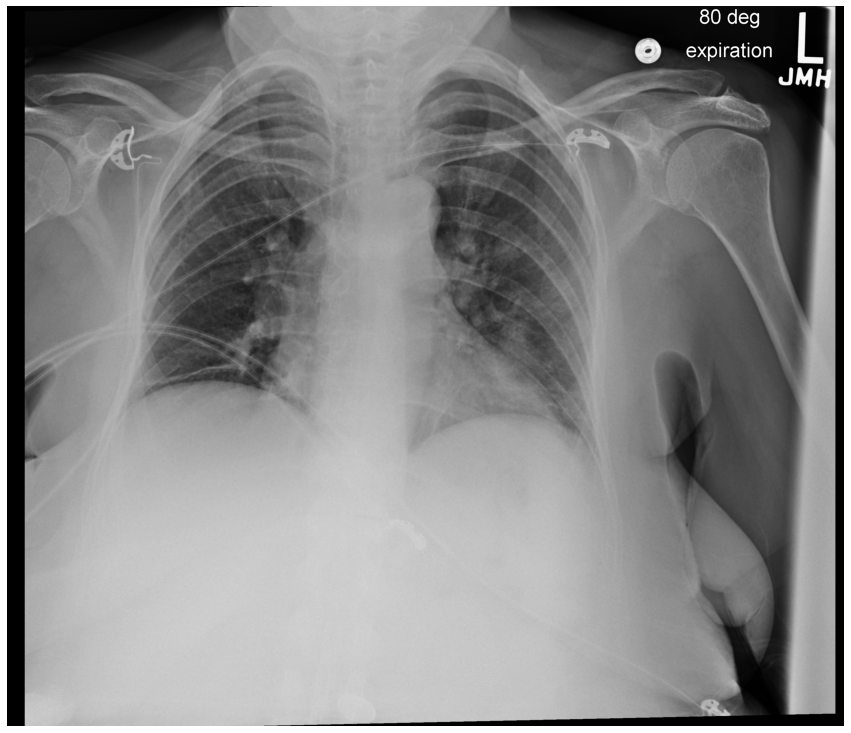

In [21]:
from pathlib import Path
from pydicom import dcmread

uifiles = list(Path('data/test').glob('*.dcm'))
dcm = dcmread(str(uifiles[1]))
image = dcm.pixel_array/4095*255   # sample image has pixel values ranging between 0 and 4095
image = np.expand_dims(image, -1)
pneumo.display([image], [None], ['gray'])

In [22]:
resized = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
resized = tf.image.grayscale_to_rgb(resized)
resized = tf.keras.applications.mobilenet_v2.preprocess_input(resized)
resized.shape

TensorShape([640, 640, 3])

In [23]:
predicted = model.predict(tf.expand_dims(resized,0))

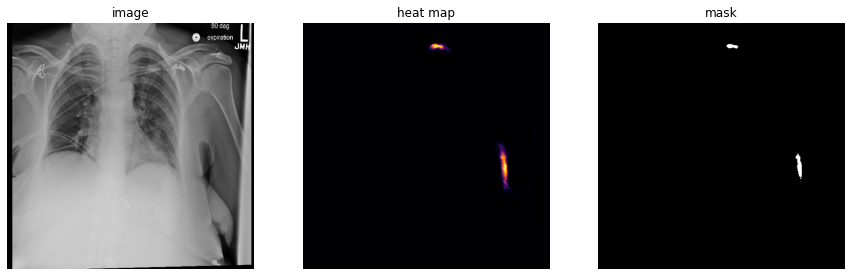

In [24]:
pneumo.display(
    [resized, tf.sigmoid(predicted[0]), tf.sigmoid(predicted[0]) > 0.5],
    ["image", 'heat map', 'mask'],
    ['gray', 'inferno', 'gray']
)